<a href="https://colab.research.google.com/github/pankosmas/NLP-in-Mobile-Journalism/blob/main/notebooks/Text_Classification_Comparison_GreekBERT_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
# Step 1: Mount Google Drive
# from google.colab import drive
# import os

# drive.mount('/content/drive')

# Replace with your JSON file path in Google Drive
json_file_path = "/content/drive/MyDrive/datasets/data.json"


In [ ]:
# Step 2: Install Required Libraries
!pip install transformers datasets scikit-learn evaluate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from evaluate import load
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [ ]:
# Step 3: Load and Preprocess Data
def filter_data(json_file_path):
    with open(json_file_path, "r") as f:
        data = json.load(f)
    return (doc for doc in data if "processed_text" in doc and "assigned_category" in doc)

filtered_data = list(filter_data(json_file_path))
texts = [doc["processed_text"] for doc in filtered_data]
labels = [doc["assigned_category"] for doc in filtered_data]

# Preprocess labels
unique_labels = sorted(set(labels))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}  # Reverse mapping
labels = [label_to_id[label] for label in labels]

# Split into train, validation, and test sets
from sklearn.model_selection import train_test_split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [ ]:
# Step 4: Tokenization
model_names = ["nlpaueb/bert-base-greek-uncased-v1", "distilbert-base-multilingual-cased"]
tokenizers = [AutoTokenizer.from_pretrained(name) for name in model_names]

# Tokenize datasets
def tokenize_data(tokenizer, texts, labels):
    tokenized_data = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
    tokenized_data["labels"] = labels
    return Dataset.from_dict(tokenized_data)

train_data = [tokenize_data(tokenizer, train_texts, train_labels) for tokenizer in tokenizers]
val_data = [tokenize_data(tokenizer, val_texts, val_labels) for tokenizer in tokenizers]
test_data = [tokenize_data(tokenizer, test_texts, test_labels) for tokenizer in tokenizers]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# Step 5: Load Models
models = [AutoModelForSequenceClassification.from_pretrained(name, num_labels=len(label_to_id)) for name in model_names]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 6: Training and Evaluation
def train_and_evaluate(model, tokenizer, train_dataset, val_dataset, test_dataset, id_to_label):
    metric = load('accuracy')

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=1)
        accuracy = metric.compute(predictions=predictions, references=labels)
        return {"accuracy": accuracy["accuracy"]}

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Evaluate on test set
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    metrics = classification_report(
        test_dataset["labels"],
        preds,
        target_names=[id_to_label[i] for i in range(len(id_to_label))],
        output_dict=True
    )

    return metrics, confusion_matrix(test_dataset["labels"], preds)

In [ ]:
# Step 7: Run for Both Models
results = {}
for i, model in enumerate(models):
    metrics, cm = train_and_evaluate(model, tokenizers[i], train_data[i], val_data[i], test_data[i], id_to_label)
    results[model_names[i]] = {"metrics": metrics, "confusion_matrix": cm}

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-31fab4af19fb>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.679000,0.521811,0.825000
2,0.433500,0.500509,0.840027
3,0.195600,0.627095,0.838963
4,0.156400,0.797207,0.842021
5,0.002400,0.884350,0.838830


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-31fab4af19fb>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.795500,0.724578,0.767686
2,0.605400,0.635685,0.791888
3,0.432600,0.605422,0.809176
4,0.231600,0.632942,0.811037
5,0.141300,0.654877,0.814495


In [ ]:
# Save results to a file
results_file = '/content/drive/MyDrive/datasets/classification_results.json'
# Convert confusion matrices to lists for JSON serialization
for model_name in results:
    results[model_name]["confusion_matrix"] = results[model_name]["confusion_matrix"].tolist()

with open(results_file, 'w') as f:
    json.dump(results, f)

# Print metrics and confusion matrices
for model_name, result in results.items():
    print(f"\nResults for {model_name}")
    print("Metrics:")
    print(result["metrics"])
    print("Confusion Matrix:")
    print(result["confusion_matrix"])


Results for nlpaueb/bert-base-greek-uncased-v1
Metrics:
{'Lifestyle': {'precision': 0.7535545023696683, 'recall': 0.7989949748743719, 'f1-score': 0.775609756097561, 'support': 199.0}, 'Έγκλημα, Νόμος, Δικαιοσύνη': {'precision': 0.8221070811744386, 'recall': 0.8847583643122676, 'f1-score': 0.8522829006266786, 'support': 538.0}, 'Αθλητισμός': {'precision': 0.9163179916317992, 'recall': 0.946685878962536, 'f1-score': 0.9312544294826365, 'support': 694.0}, 'Διαμάχη, Πόλεμος, Ειρήνη': {'precision': 0.8205479452054795, 'recall': 0.8160762942779292, 'f1-score': 0.8183060109289617, 'support': 734.0}, 'Εκπαίδευση': {'precision': 0.8581560283687943, 'recall': 0.8344827586206897, 'f1-score': 0.8461538461538461, 'support': 145.0}, 'Επιστήμη και Τεχνολογία': {'precision': 0.7945736434108527, 'recall': 0.7192982456140351, 'f1-score': 0.7550644567219152, 'support': 285.0}, 'Εργασία': {'precision': 0.8153846153846154, 'recall': 0.7910447761194029, 'f1-score': 0.803030303030303, 'support': 201.0}, 'Θρ

In [ ]:
# Evaluate on validation set
results = trainer.evaluate()

# Print accuracy and loss
print(f"Validation Loss: {results['eval_loss']}")
print(f"Validation Accuracy: {results['eval_accuracy']}")

NameError: name 'trainer' is not defined

Confusion Matrix for nlpaueb/bert-base-greek-uncased-v1


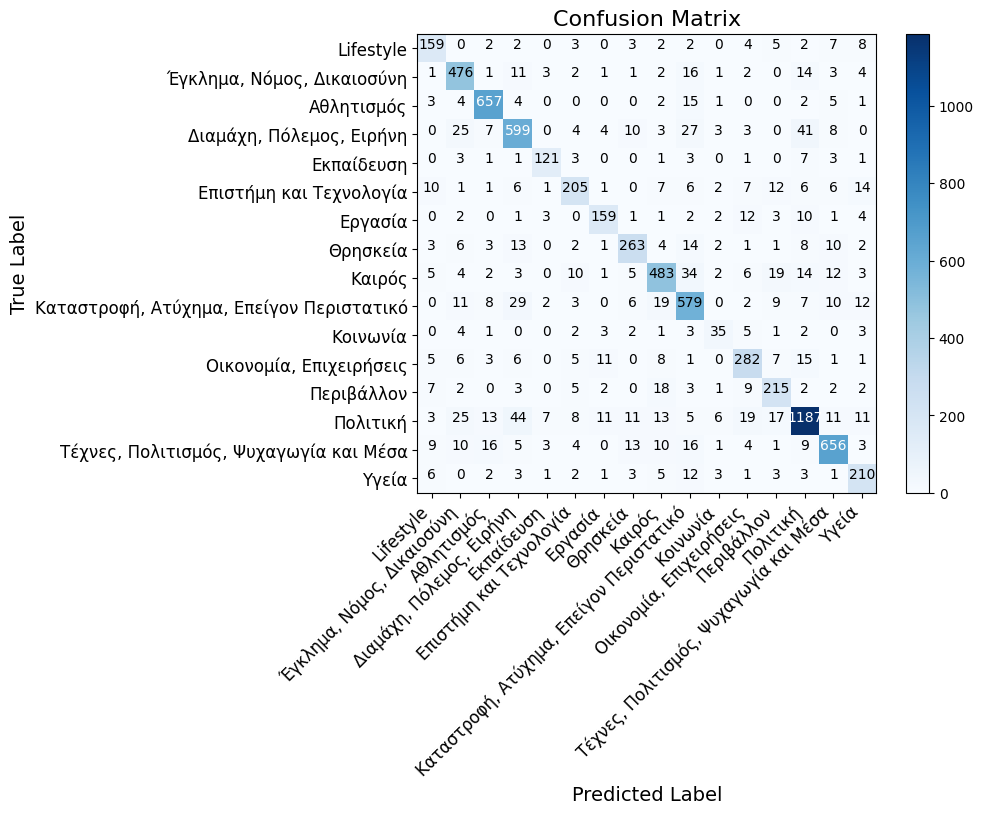

Confusion Matrix for distilbert-base-multilingual-cased


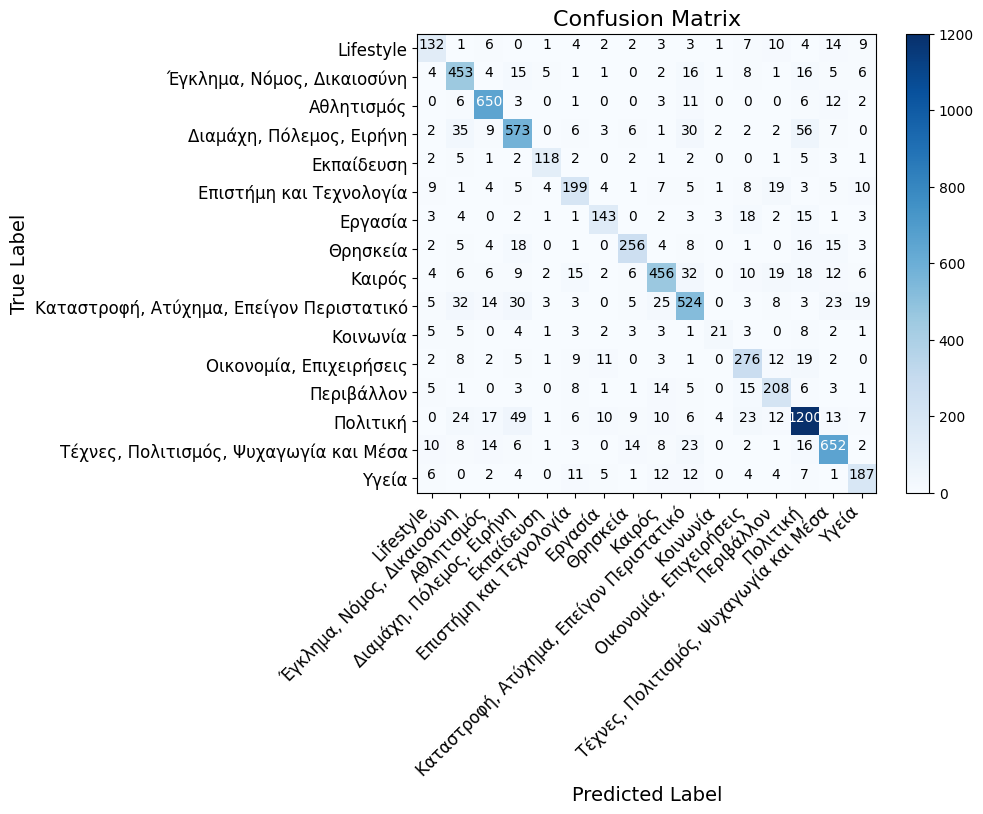

In [ ]:
# Step 8: Visualize Confusion Matrix
def plot_confusion_matrix(cm, labels):
    cm = np.array(cm)  # Convert cm to NumPy array
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)  # Adjust rotation and alignment
    plt.yticks(tick_marks, labels, fontsize=12)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

    plt.tight_layout()  # Ensures labels and title fit properly
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.show()


for model_name, result in results.items():
    print(f"Confusion Matrix for {model_name}")
    plot_confusion_matrix(result["confusion_matrix"], [id_to_label[i] for i in range(len(id_to_label))])